# Sparse Linear Algebra

So far, we have seen how sparse matrices and linear operators can be used to speed up basic matrix-vector and matrix-matrix operations, and decrease the memory footprint of the representation of a linear map.

Just as there are special data types for sparse and structured matrices, there are specialized linear algebra routines which allow you to take advantage of sparsity and fast matrix-vector products.

Routines for sparse linear algebra are found in `scipy.sparse.linalg`, which we'll import as `sla`

In [1]:
%pylab inline
import scipy.sparse as sparse
import scipy.sparse.linalg as sla

Populating the interactive namespace from numpy and matplotlib


## Sparse Direct Methods

This typically refers to producing a factorization of a sparse matrix for use in solving linear systems.

The thing to keep in mind is that many factorizations will generally be dense, even if the original matrix is sparse.  E.g. eigenvalue decompositions, QR decomposition, SVD, etc.  This means that if we compute a factorization, we are going to lose all the advantages we had from sparsity.  

What we really want is a factorization where if `A` is sparse, the terms in the factorization are also sparse.  The factorization where this is easiest to achieve is the LU decomposition.  In general, the `L` and `U` terms will be more dense than `A`, and sometimes much more dense.  However, we can seek a permuted version of the matrix `A` which will minimize the amount of "fill-in" which occurs.  This is often done using "nested disection" algorithm, which is outside the scope of this course.  If you ever need to do this explicitly, the [METIS package](http://glaros.dtc.umn.edu/gkhome/metis/metis/overview) is commonly used.

We'll just use the function [`sla.splu`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.splu.html#scipy.sparse.linalg.splu) (SParse LU) at a high level, which produces a factorization object that can be used to solve linear systems.

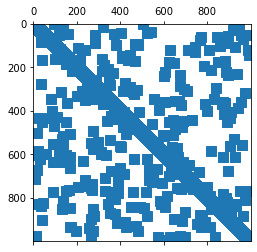

In [2]:
n = 1000
A = 0.001*sparse.random(n, n, 0.0003) + sparse.eye(n)
plt.spy(A)
plt.show()

In [3]:
A = A.tocsc() # need to convert to CSC form first
LU = sla.splu(A)
LU

The resulting object stores the factors necessary to compute `A = PLUQ` (`P` permutes rows, and `Q` permutes columns).  It is computed using the [SuperLU library](https://portal.nersc.gov/project/sparse/superlu/).  Typically, you will just use the `solve` method on this object.

In [4]:
x = np.random.randn(n)
b = A @ x

x2 = LU.solve(b)
print(np.linalg.norm(x2 - x))

3.2129401761290203e-16


you can also use the `sla.spsolve` function, which wraps this factorization.

In [5]:
x2 = sla.spsolve(A, b)
print(np.linalg.norm(x2 - x))

3.2129401761290203e-16


## Sparse Iterative Methods

Sparse iterative methods are another class of methods you can use for solving linear systems built on [Krylov subspaces](https://en.wikipedia.org/wiki/Krylov_subspace).  They only require matrix-vector products, and are ideally used with sparse matrices and fast linear operators.  You can typically learn the theory behind these methods in a numerical linear algebra course - we'll just talk about how to use them. 

All these methods are meant to solve linear systems: find `x` so that `A @ x = b`, or least squares problems minimizing `norm(A @ x - b)`

You can find a list of options in the [documentation for `scipy.sparse.linalg`](https://docs.scipy.org/doc/scipy/reference/sparse.linalg.html#solving-linear-problems).  Here are some common options:

* Conjugate Gradient: `sla.cg` for `A` SPD
* MINRES: `sla.minres` for `A` symmetric
* GMRES: `sla.gmres` for general square `A`
* LSQR: `sla.lsqr` for solving least squares problems

For example, we can use `gmres` with the same matrix we used for `splu`:

In [6]:
x2, exit = sla.gmres(A, b, tol=1e-2) # exit code: 0 if successful
print(np.linalg.norm(x2 - x))

0.00956720325860978


In [7]:
import time
x2 = np.empty_like(x)

t0 = time.time()
x2, exit = sla.gmres(A, b)
t1 = time.time()
print("GMRES in {} sec.".format(t1 - t0))

t0 = time.time()
x2 = sla.spsolve(A, b)
t1 = time.time()
print("spsolve in {} sec.".format(t1 - t0))

GMRES in 0.001146078109741211 sec.
spsolve in 0.0008590221405029297 sec.


GMRES also works for other LinearOperator $A$ that can be applied fast, e.g. low rank + sparse. 

In [8]:
from scipy.sparse.linalg import LinearOperator, aslinearoperator
import numpy.linalg as la

n = 1000
onesn = aslinearoperator(np.ones((n,1)))
eyem  = aslinearoperator(np.eye(n))
Alo = eyem + 0.01*onesn @ onesn.T
As  = sparse.csc_matrix(np.eye(n) + np.ones((n,n)))

x = np.random.randn(n)
b = A @ x

t0 = time.time()
x2, exit = sla.gmres(Alo, b)
t1 = time.time()
print("GMRES in {} sec.".format(t1 - t0))

t0 = time.time()
x2 = sla.spsolve(As, b)
t1 = time.time()
print("sparse in {} sec.".format(t1 - t0))

GMRES in 0.009238958358764648 sec.
sparse in 0.07565903663635254 sec.


## Exercises
Code up a gradient descent algorithm for optimizing $(1/2) x^T A x - b^T x$. Test with diagonal $A$ with diagonal $1,2,3,\ldots,n$ and $1^2,2^2,\ldots,n^2$. Test with different step size to see for what step size it converges. Check the rate of convergence. The algorithm should take input $A, b$, stepsize (use constant stepsize), tolerance, and maximum number of iterations. First test with $A$ being $1\times 1$ with various values of $A$.

In [31]:
def gradient_descent(A, b, tau=1, tol=1e-2, max_iter=500):

    
    x      = np.zeros(A.shape[1])
    res    = []
    res.append(la.norm(A @ x - b))

    for i in range(0, max_iter):
        
        x = x - tau*(A @ x - b)
        
        res.append(la.norm(A @ x - b))
        
        
        if res[i]<tol:
            break
        
    
    return x, res


In [45]:
A  = np.diag(np.arange(10))
x0 = np.random.randn(10)
b  = A @ x0

[x, res] = gradient_descent(A, b, tol=1e-3, tau=0.1)
print(x-x0)

[ 2.24249966e-01  8.38757626e-04 -4.01093043e-08  1.62886371e-12
 -1.11022302e-16  0.00000000e+00  2.22044605e-16  1.11022302e-16
  0.00000000e+00  0.00000000e+00]


### Sparse Direct vs. Iterative Methods

There are a couple of trade offs to consider when deciding whether to use sparse direct or iterative algorithms.

1.  Are you going to be solving many linear systems with the same matrix `A`?  If so, you can produce a single factorization object using `splu`, and use it to solve many right-hand sides.  Sparse direct probably makes more sense.
2. Are you solving a single linear system?  If so, then a single call to an iterative method probably makes mores sense.
3. Are you using a fast linear operator that could be expressed as a dense matrix (e.g. sparse plus low-rank)?  Alternatively, would the sparse LU decomposition turn dense because of fill-in?  If so, then iterative methods probably make more sense.
4. Do you have a really good preconditioner (see below)?  Then iterative methods probably make more sense.

### Preconditioning

The speed/effectiveness of iterative methods is often dependent on the existence of a good preconditioner. A preconditioner `M` for a matrix `A` is an "approximate inverse" i.e. `M @ A` is close to the identity.  Note if we had an exact inverse, we've solved our problem already.  What we want is to have a matrix `M` which is fast to apply (i.e. also sparse like `A`), which generally isn't possible with an exact inverse.

Finding a good preconditioner is a huge field of research, and can be very domain-dependent.  A general-purpose method to obtain a preconditioner is to use an Incomplete LU decomposition (this is an LU factorization that stops when the fill-in gets too large). You can obtain one using `sla.spilu`.

In [46]:
ILUfact = sla.spilu(A)

You can construct a preconditioner using a `LinearOperator` around the ILU object's solve method

In [47]:
M = sla.LinearOperator(
    shape = A.shape,
    matvec = lambda b: ILUfact.solve(b)
)

In [48]:
x2, exit = sla.gmres(A, b, M=M) # exit code: 0 if successful
print(np.linalg.norm(x2 - x))

6.81655976787981e-15


In [50]:
t0 = time.time()
x2, exit = sla.gmres(A, b)
t1 = time.time()
print("GMRES in {} sec.".format(t1 - t0))
print(np.linalg.norm(x2 - x))

t0 = time.time()
x2, exit = sla.gmres(A, b, M=M)
t1 = time.time()
print("preconditioned GMRES in {} sec.".format(t1 - t0))
print(np.linalg.norm(x2 - x))

GMRES in 0.0014529228210449219 sec.
2.7063399512451093e-06
preconditioned GMRES in 0.0010259151458740234 sec.
6.81655976787981e-15


We get a higher-precision answer in about the same amount of time.

## Eigenvalues and Eigenvectors

Computing a full eigenvalue decomposition of a sparse matrix or fast linear operator doesn't typically make sense (see the the discussion for sparse direct methods).  However, there are a lot of situations in which we want to compute the eigenvalue-eigenvector pairs for a handful of the largest (or smallest) eigenvalues.  

`scipy.sparse.linalg` wraps [ARPACK (ARnoldi PACKage)](https://www.caam.rice.edu/software/ARPACK/), which uses Krylov subspace techniques (like the iterative methods) to compute eigenvalues/eigenvectors using matrix-vector multiplications.  The relevant methods are `sla.eigs` (for general square matrices) and `sla.eigsh` (for symmetric/Hermitian matrices).  There is also a `sla.svds` function for the SVD.

Let's look at an example for a linear operator which acts as the matrix of all ones.

In [53]:
# works on square matrices
Afun = lambda X : np.sum(X, axis=0).reshape(1,-1).repeat(X.shape[0], axis=0)

m = 10 # linear operator of size 10

A = sla.LinearOperator(
    shape   = (m,m),
    matvec  = Afun,
    rmatvec = Afun,
    matmat  = Afun,
    rmatmat = Afun,
    dtype=float   
)

This operator is Hermitian, so we'll use `eigsh`.  By default, `eigsh` will compute the largest magnitude eigenvalues.  You can change which eigenvalues you're looking for using the `which` keyword argument, and the number of eigenvalues using the `k` argument.  See [the documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigsh.html#scipy.sparse.linalg.eigsh) for details.

In [54]:
Lam, V = sla.eigsh(A)

In [55]:
Lam

array([-5.19306142e-17, -1.26876724e-32, -1.22328827e-32,  2.19128633e-32,
        1.82828745e-15,  1.00000000e+01])

we see there is one eigenvalue with a numerically non-zero value (10).  Let's take a look at the eigenvector

In [56]:
V[:,-1]

array([-0.31622777, -0.31622777, -0.31622777, -0.31622777, -0.31622777,
       -0.31622777, -0.31622777, -0.31622777, -0.31622777, -0.31622777])

this is the vector with constant entries.  This agrees with our understanding of the operator `A`, which can be expressed as the symmetric rank-1 outer product of the vector with 1s in every entry.

## Randomized Linear Algebra

In the past decade or two, randomized linear algebra has matured as a topic with lots of practical applications.  To read about the theory, see the 2009 paper by Halko, Martinsson, and Tropp: [Link](http://users.cms.caltech.edu/~jtropp/papers/HMT11-Finding-Structure-SIREV.pdf).

SciPy does not (currently) have built-in functions for randomized linear algebra functionality (some languages like Julia do).  Fortunately, these algorithms are very easy to implement without worrying too much about the theory.

For simplicity, we'll assume that `A` is symmetric with distinct eigenvectors, so we can limit the discussion to eigenvectors.  A rank-`k` approximation of `A` is an approximation by a rank-`k` outer product.  We can analyitically obtain the optimal rank-`k` approximation by computing a full eigenvalue decomposition of `A` and set all the eigenvalues outside the largest `k` (in magnitude) to 0.  Again, we don't want to actually compute the full eigenvalue decomposition, so we want an algorithm that does this in some provable way.

The basic idea is to get an approximation of the range of an operator `A` by applying it to a bunch of random vectors. That is, we compute `A @ X`, where `X` is a matrix with random entries (we think of every column as a random vector). One way to think about the action of `A` is that it "rotates" these random vectors preferentially in the direction of the top eigenvectors, so if we look at the most important subspace of the span of the image  `A @ X` (as measured by the svd), we get a good approximation of the most important eigenspace.

Randomized algorithms have probabilistic gurarantees.  The statement is roughly that if entries of `X` are iid sub-Gaussian random variables (you can replace "sub-Gaussian" with Gaussian), and if we use `k+p` random vectors (`p` is a small constant), we can get close to the top-`k` dimensional eigenspace *with high probability*.  In this case, *close* depends on something called the spectral gap, and *with high probability* means that in order to **not** be close to the desired subspace you would likely need to keep running computations with different random numbers for millions or billions of years before you would observe the algorithm fail.

Let's see how this works in practice:

In [17]:
import scipy.linalg as la

def random_span_k(A, k, p=10, power=0):
    """
    Compute subspace whose span is close to contaning the top-k eigenspace of A
    
    p = number of dimensions to pad
    power : number of times to run a power iteration on the subspace
    """
    m, n = A.shape
        
    X = np.random.randn(n, k+p)
    Y = A @ X
    
    U, s, Vt = la.svd(Y, full_matrices=False)
    
    for i in range(power):
        Y = A @ U
        U, s, Vt = la.svd(Y, full_matrices=False)
    
    
    return U

Let's test this on a diagonal matrix with entries 0 to `n-1` along the main diagonal.  In this case, the eigenvalues are integers, and the eigenvectors are the standard basis vectors.

In [18]:
n = 100
D = sparse.dia_matrix((np.arange(n), [0]), shape=(n,n))
D

<100x100 sparse matrix of type '<class 'numpy.int64'>'
	with 100 stored elements (1 diagonals) in DIAgonal format>

In [19]:
k = 5
U = random_span_k(D, k)

In [20]:
lam, V = la.eigh(D.todense())
V_true = V[:,-k:]
V_true[-k:,:] # should see identity

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

Let's take a look at how well `U` captures each eigenvector.  The distance from this subspace from the `i`th eigenvector is `norm(V[:,i].T*U)`.  Because the eigenvectors are canonical basis vectors, this is just the norm of the `i`th row of `U`

In [21]:
for i in range(n):
    print("{:02d} : {}".format(i, np.linalg.norm(U[i])))

00 : 1.6109595277541277e-16
01 : 0.006633617127962858
02 : 0.023534695279880627
03 : 0.02377494077825631
04 : 0.026477934577673966
05 : 0.027262832798361943
06 : 0.038796736650639305
07 : 0.04503690478151045
08 : 0.05851953567352757
09 : 0.09563299793442269
10 : 0.06093463168658657
11 : 0.07691477197743891
12 : 0.09604844251272544
13 : 0.065872408785975
14 : 0.1208464529012689
15 : 0.1701561123423938
16 : 0.19869551371606198
17 : 0.1645650622860826
18 : 0.10884115384520589
19 : 0.14211540156282776
20 : 0.17732555923544413
21 : 0.19157693358863795
22 : 0.23139553158260584
23 : 0.21779351324283602
24 : 0.1418120421968261
25 : 0.1145638658509435
26 : 0.2245040063249675
27 : 0.25214718490486393
28 : 0.27935158492507756
29 : 0.15633444469518384
30 : 0.20807300660261296
31 : 0.17977954661300843
32 : 0.32569470087758867
33 : 0.22135035834364042
34 : 0.2552979591899163
35 : 0.21554246596410825
36 : 0.31268499528071503
37 : 0.25788398894521863
38 : 0.3020382888968165
39 : 0.3290269083301098
40 

As we see, `U` is closer to the larger eigenvectors, rather than the smaller eigenvectors.

We can improve this estimate by running a couple of power iterations on the subspace (the `power` keyword defined above):

In [22]:
U = random_span_k(D, k, power=5)
for i in range(n):
    print("{:02d} : {}".format(i, np.linalg.norm(U[i])))

00 : 7.958959704453304e-17
01 : 2.916496551801577e-12
02 : 1.5488209242149182e-10
03 : 1.8873951611515672e-09
04 : 1.2589094319306354e-08
05 : 4.268103801432829e-08
06 : 1.0304216514054878e-07
07 : 3.899699240444164e-07
08 : 4.631287997911403e-07
09 : 1.3689886608365438e-06
10 : 1.8855366507575138e-06
11 : 7.43169878555308e-06
12 : 8.564345553369577e-06
13 : 1.6534197549019153e-05
14 : 2.544284797788348e-05
15 : 3.908658770660757e-05
16 : 3.8694352678965526e-05
17 : 5.092830171274271e-05
18 : 7.324705386486573e-05
19 : 0.00011961353563798645
20 : 0.00010259615750577138
21 : 0.00017488264846066826
22 : 0.0002930332274596114
23 : 0.0003098032324709351
24 : 0.0004694779579575787
25 : 0.0010485166781785556
26 : 0.0006068797966368376
27 : 0.0010294948662544162
28 : 0.0011032539999480339
29 : 0.0013197789607760754
30 : 0.0016159140133598271
31 : 0.0021465604093732662
32 : 0.0034442630741350843
33 : 0.0036418266417170917
34 : 0.0051843610005941915
35 : 0.005135032147916564
36 : 0.007043228791

## Exercises

Download a couple of test matrices from the UFlorida Sparse Matrix collection [Link](https://sparse.tamu.edu/)
For, example, use `mnist_test_norm_10NN` [Link](https://sparse.tamu.edu/ML_Graph/mnist_test_norm_10NN) which would probably be too large to store on your computer as a dense matrix.

For each square matrix:
1. Solve a random linear system using `splu`
2. Solve a random linear system using either `minres` or `gmres` (which one should you use?)
3. Compute the largest magnitude eigenvector using `eigs` or `eigsh` (which one should you use?)

Find a non-square matrix and
1. Solve a random least squares problem using `lsqr`
2. Compute the largest singular vectors using `svds`

In [23]:
## Your code here

